# 5. Light Curve State Definition
#### (Scripts 03b,04b,05,06)
With the event files cleaned and checked for pile-up, the next step is to divide the spectrum into different time intervals based on the variability of the light curve.

This script loads the raw light curve extracted from the event file, visualizes the count rate over time, and maps it to the orbital phase. The goal is to visually identify and define the time intervals corresponding to different states: Eclipse, Dips, Shallow Dips, and Persistent emission.
### Workflow:

### **Part 1**: Define Time Intervals
In the first part, we load and plot the raw light curve to visually inspect it and define the time intervals for each variability state.

Look at the plot to identify the start and stop times (in seconds relative to TSTART) for distinct features:

    Eclipse: Sharp, deep drop in count rate (occultation by companion).

    Dips: Irregular variability and hardening.

    Shallow Dips: Mild reductions in count rate.

    Persistent: Stable emission levels.

Plot the light curve again, this time shading the defined intervals for each state.

The code below generates the necessary configuration strings for the subsequent time-resolved spectral extraction scripts.

   **Edit step**: Manually update the interval variables in the "Configuration" section of the scripts 05_extract_time_spectra.sh (EPIC) and 03b_extract_rgs_time_spectra.sh (RGS)


### **Part 2**: Define Flux Threshold

In the next step, the flux threshold is calculated for the dipping interval. Visually inspect the flux distribution within the dipping interval to identify the threshold value.

We choose to define the threshold as 50% of the average persistent rate.

   **Edit step**: Update the flux_threshold variable in the "Configuration" section of the scripts 06_extract_flux_resolved_spectra.sh (EPIC) and 04b_extract_rgs_flux_resolved.sh (RGS)



In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from IPython.display import Image, display
# --- USER CONFIGURATION ---
# Set the path to your project root and the specific observation ID
os.environ['PROJECT_ROOT'] = '/media/kyle/kyle_phd/Swift-j1858.6-0814/'
os.environ['OBSID'] = '/0865600201'

project_root = os.environ.get('PROJECT_ROOT')
obsid = os.environ.get('OBSID')

# Ensure directories exist for logs
os.makedirs('logs', exist_ok=True)

print(f"Project Root: {project_root}")
print(f"ObsID: {obsid}")

Project Root: /media/kyle/kyle_phd/Swift-j1858.6-0814/
ObsID: /0865600201


## Part 1: Main Light Curve & State Definition
Define Time Intervals (EPIC & RGS)

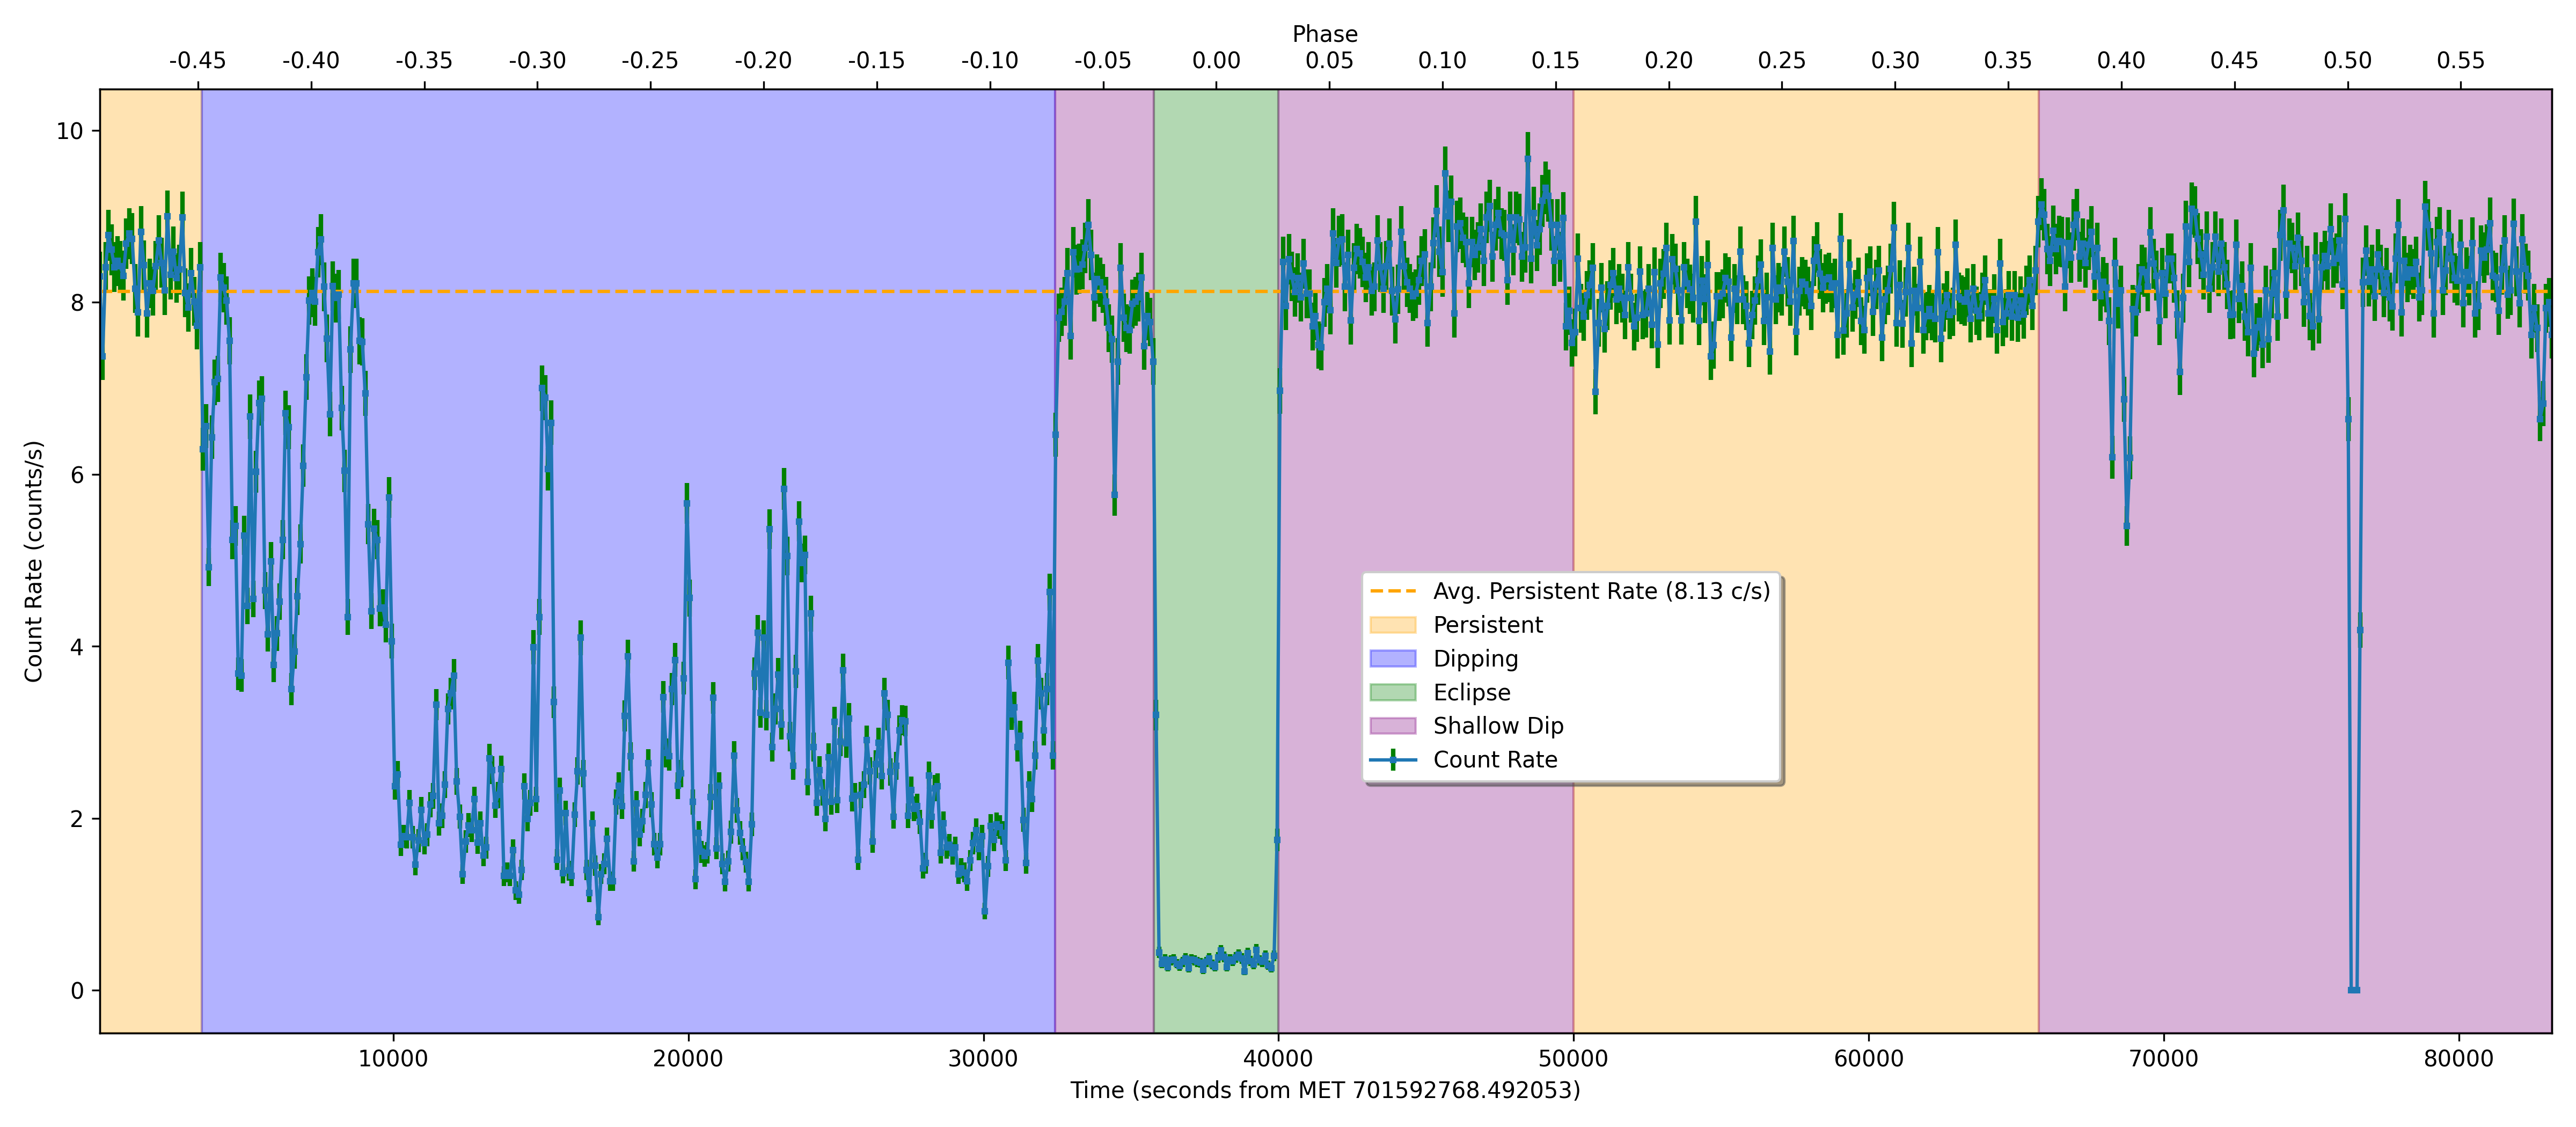

In [38]:
# --- Configuration ---
# Define path to the raw lightcurve
lc_file_path = f"{project_root}/products/{obsid}/pn/lc/pn_source_lc_raw.fits"

# --- Data Loading ---
with fits.open(lc_file_path) as hdul:
    # Load Header and Data
    header = hdul[1].header
    lc_table = Table(hdul[1].data)

    tstart = header['TSTART'] # MET start time
    tend = header['TSTOP']

# Extract columns
time = lc_table['TIME']
rate = lc_table['RATE']
error = lc_table['ERROR']

# --- Pre-processing ---
# Create mask for valid data points (remove NaNs and Infs)
valid_mask = np.isfinite(rate) & np.isfinite(error)

# Apply mask to all arrays immediately to keep them synchronized
time_clean = time[valid_mask]
rate_clean = rate[valid_mask]
error_clean = error[valid_mask]

# Convert to relative time
time_relative = time_clean - tstart

# --- Define Intervals (Visual Inspection) ---
# Note: Ensure these match the visual cues from your specific observation
persistent_intervals = [(time_relative[0], 3510), (50000, 65760)]
dipping_intervals = (3510, 32430)
eclipse_intervals = (35780, 40000)
shallow_dip_intervals = [(32430, 35780), (40000, 50000), (65760, time_relative[-1])]

# --- Calculations ---
# 1. Average Persistent Rate
# Create a boolean mask for all persistent segments
persistent_mask = np.zeros_like(time_relative, dtype=bool)
for start, end in persistent_intervals:
    persistent_mask |= (time_relative >= start) & (time_relative <= end)

average_persistent_rate = rate_clean[persistent_mask].mean()

# --- Plotting Main Light Curve ---
fig, ax1 = plt.subplots(figsize=(16, 7), dpi=100)

# Plot Data
ax1.errorbar(time_relative, rate_clean, yerr=error_clean, fmt='s-',
             markersize=2, alpha=1, elinewidth=2, ecolor='green', label='Count Rate')

# Plot Average Persistent Level
ax1.hlines(average_persistent_rate, time_relative[0], time_relative[-1],
           colors='orange', linestyles='dashed',
           label=f'Avg. Persistent Rate ({average_persistent_rate:.2f} c/s)')

# Highlight Intervals
# Persistent
for i, (start, end) in enumerate(persistent_intervals):
    label = 'Persistent' if i == 0 else None
    ax1.axvspan(start, end, color='orange', alpha=0.3, label=label)

# Dipping
ax1.axvspan(dipping_intervals[0], dipping_intervals[1], color='blue', alpha=0.3, label='Dipping')

# Eclipse
ax1.axvspan(eclipse_intervals[0], eclipse_intervals[1], color='green', alpha=0.3, label='Eclipse')

# Shallow Dip
for i, (start, end) in enumerate(shallow_dip_intervals):
    label = 'Shallow Dip' if i == 0 else None
    ax1.axvspan(start, end, color='purple', alpha=0.3, label=label)

# Formatting Ax1
ax1.set_xlabel(f'Time (seconds from MET {tstart:f})')
ax1.set_ylabel('Count Rate (counts/s)')
ax1.legend(fancybox=True, shadow=True, loc='upper center', bbox_to_anchor=(0.6, 0.5))
ax1.set_xlim(time_relative[0], time_relative[-1])

# --- Secondary Axis (Phase) ---
ax2 = ax1.twiny()

period_seconds = 21.3 * 3600
t0 = (eclipse_intervals[0] + eclipse_intervals[1]) / 2  # Midpoint of eclipse

def time_to_phase(t):
    return (t - t0) / period_seconds

# Map limits
x_min, x_max = ax1.get_xlim()
ax2.set_xlim(time_to_phase(x_min), time_to_phase(x_max))

# Formatting Ax2
ax2.set_xlabel("Phase")
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.xaxis.set_major_locator(MultipleLocator(0.05))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.tight_layout()

# Save and Display
plot_path = f"{project_root}/products/{obsid}/pn/lc/pn_states_lc.png"
fig.savefig(plot_path, dpi=300)
plt.close()
display(Image(filename=plot_path, width=800))

### Generate Configuration for Time-Resolved Scripts

This cell generates the specific filter strings needed for both 05_extract_time_spectra.sh (EPIC) and 03b_extract_rgs_time_spectra.sh (RGS).

In [39]:
def make_filter(intervals, t_start_met):
    """Helper to create SAS time selection string from relative intervals."""
    filters = []
    if isinstance(intervals, tuple): # Single interval
        start, end = intervals
        return f"(TIME IN [{start + t_start_met}:{end + t_start_met}])"

    for start, end in intervals: # List of intervals
        filters.append(f"(TIME IN [{start + t_start_met}:{end + t_start_met}])")
    return " || ".join(filters)

# 1. Generate Filters
filter_persistent = make_filter(persistent_intervals, tstart)
filter_dipping = make_filter(dipping_intervals, tstart)
filter_shallow = make_filter(shallow_dip_intervals, tstart)

print("--- CONFIGURATION FOR SCRIPTS ---")
print("\n[EPIC-PN] Paste into 05_extract_time_spectra.sh (TIME_FILTERS array):")
print(f'    "{filter_persistent}"')
print(f'    "{filter_dipping}"')
print(f'    "{filter_shallow}"')

print("\n[RGS] Paste into 03b_extract_rgs_time_spectra.sh (CONFIGS array):")
print(f'    "Persistent|{filter_persistent}"')
print(f'    "Dipping|{filter_dipping}"')
print(f'    "Shallow|{filter_shallow}"')

--- CONFIGURATION FOR SCRIPTS ---

[EPIC-PN] Paste into 05_extract_time_spectra.sh (TIME_FILTERS array):
    "(TIME IN [701592818.492053:701596278.492053]) || (TIME IN [701642768.492053:701658528.492053])"
    "(TIME IN [701596278.492053:701625198.492053])"
    "(TIME IN [701625198.492053:701628548.492053]) || (TIME IN [701632768.492053:701642768.492053]) || (TIME IN [701658528.492053:701675918.492053])"

[RGS] Paste into 03b_extract_rgs_time_spectra.sh (CONFIGS array):
    "Persistent|(TIME IN [701592818.492053:701596278.492053]) || (TIME IN [701642768.492053:701658528.492053])"
    "Dipping|(TIME IN [701596278.492053:701625198.492053])"
    "Shallow|(TIME IN [701625198.492053:701628548.492053]) || (TIME IN [701632768.492053:701642768.492053]) || (TIME IN [701658528.492053:701675918.492053])"


### Run Time-Resolved Extractions
Executes the scripts for both instruments. Ensure you have updated the scripts with the filters printed above.


In [ ]:
# Run EPIC-PN Time Extraction
print("Running EPIC-PN Time Extraction (05)...")
!../scripts/05_extract_time_spectra.sh > logs/05_extract_time_spectra.log 2>&1

# Run RGS Time Extraction
print("Running RGS Time Extraction (03b)...")
!../scripts/03b_extract_rgs_time_spectra.sh > logs/03b_extract_rgs_time_spectra.log 2>&1

print("Time-resolved extractions complete. Check logs/ for details.")

The time-resolved spectral extraction is now complete. The defined intervals have been processed, and the resulting spectra are available under the respective product directories for EPIC and RGS.

## Part 2: Define Flux Thresholds (Dipping Interval)

### Analyze Dipping Interval for Flux Thresholds

This section isolates the "Dipping" data defined in Part 1 and calculates the flux threshold (e.g., 50% of the average persistent rate).

--- FLUX CONFIGURATION (Dipping Region) ---
Dipping Interval Duration: 28800.0 seconds
Calculated Flux Threshold: 4.06378238341969 counts/s
28920


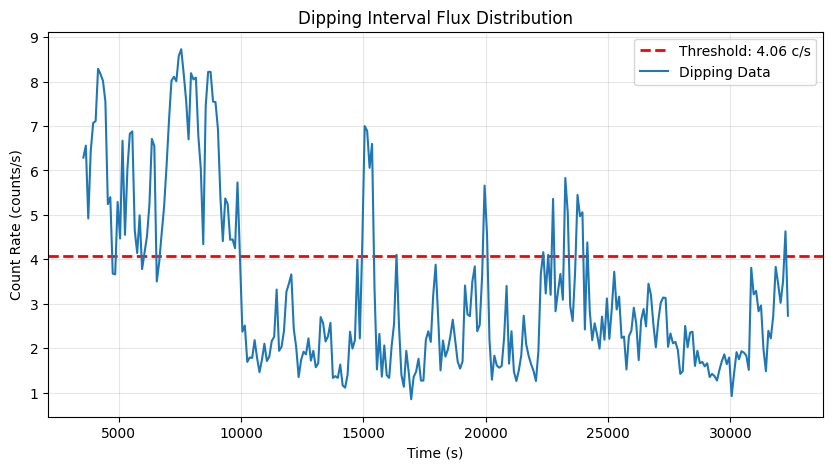

In [42]:
# --- Flux Configuration (Dipping Region Only) ---

# Create a mask specifically for the Dipping Interval
# Note: dipping_intervals is a tuple (start, end)
dipping_mask = (time_relative >= dipping_intervals[0]) & (time_relative <= dipping_intervals[1])

# Extract rate and time for just the dipping region
dipping_rate = rate_clean[dipping_mask]
dipping_time = time_relative[dipping_mask]

if len(dipping_rate) > 0:
    # Calculate Flux Threshold (50% of Average Persistent Rate)
    flux_threshold = 0.5 * average_persistent_rate

    print(f"--- FLUX CONFIGURATION (Dipping Region) ---")
    print(f"Dipping Interval Duration: {dipping_time[-1] - dipping_time[0]} seconds")

    print(f"Calculated Flux Threshold: {flux_threshold} counts/s")


    # Plot the threshold zoom-in
    plt.figure(figsize=(10, 5), dpi=100)
    plt.errorbar(dipping_time, dipping_rate, ls='-', markersize=4, label='Dipping Data')
    plt.axhline(flux_threshold, color='red', linewidth=2, linestyle='--', label=f'Threshold: {flux_threshold:.2f} c/s')

    plt.xlabel('Time (s)')
    plt.ylabel('Count Rate (counts/s)')
    plt.title('Dipping Interval Flux Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Error: No data points found within the defined dipping interval.")

### Generate Configuration for Flux-Resolved Scripts
This cell generates the configuration variables for 06_extract_flux_resolved_spectra.sh (EPIC) and 04b_extract_rgs_flux_resolved.sh (RGS).

In [22]:
print("--- CONFIGURATION FOR SCRIPTS ---")
print(f"\n[BOTH] Paste into 06 (EPIC) and 04b (RGS):")
print(f'DIP_TIME_FILTER="{filter_dipping}"')
print(f'FLUX_THRESHOLD={flux_threshold}')

--- CONFIGURATION FOR SCRIPTS ---

[BOTH] Paste into 06 (EPIC) and 04b (RGS):
DIP_TIME_FILTER="(TIME IN [701596278.492053:701625198.492053])"
FLUX_THRESHOLD=4.06378238341969


### Run Flux-Resolved Extractions
Executes the flux-resolved scripts for both instruments.

In [ ]:
# Run EPIC-PN Flux Extraction
print("Running EPIC-PN Flux Extraction (06)...")
!../scripts/06_extract_flux_resolved_spectra.sh > logs/06_extract_flux_resolved_spectra.log 2>&1

# Run RGS Flux Extraction
print("Running RGS Flux Extraction (04b)...")
!../scripts/04b_extract_rgs_flux_resolved.sh > logs/04b_extract_rgs_flux_resolved.log 2>&1

print("Flux-resolved extractions complete. Check logs/ for details.")

The flux-resolved spectral extraction is now complete. The spectra corresponding to the defined flux separation within the dipping interval are available under the respective product directories for EPIC and RGS.